In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_parquet('data/hh.parquet')
edu = pd.read_parquet('data/education.parquet')
food = pd.read_parquet('data/food.parquet')
health = pd.read_parquet('data/health.parquet')
ration = pd.read_parquet('data/ration.parquet')
services = pd.read_parquet('data/services.parquet')

df = pd.concat([df, edu, food, health, ration, services], axis=1, verify_integrity=True)

In [2]:
df.head()

,sector,nss_region,multiplier,family_size,n_children,n_schoolchildren,n_elderly,n_school_meals,employed_annual,nco_2015,...,received_free_electricity,is_hhmem_edu,num_hhmem_privedu,received_free_stationary,received_free_schoolbag,received_fee_waiver,is_hhmem_pmjay,is_hospitalization,is_benefit_healthscheme,received_free_school_oth
hhid,,,,,,,,,,,,,,,,,,,,,
46667201,rural,12,16669,5,0,0,0,0.0,yes,112.0,...,2,1,0.0,NaN,NaN,2.0,1,4,NaN,NaN
46667301,rural,12,24840,4,0,0,0,0.0,yes,233.0,...,1,2,NaN,NaN,NaN,NaN,1,4,NaN,NaN
46667302,rural,12,24840,5,3,3,0,0.0,yes,832.0,...,1,1,3.0,NaN,NaN,2.0,1,4,NaN,NaN
46667303,rural,12,24840,5,1,1,1,0.0,yes,741.0,...,2,1,1.0,NaN,NaN,2.0,1,4,NaN,NaN
46667304,rural,12,24840,3,0,0,2,0.0,no,NaN,...,2,2,NaN,NaN,NaN,NaN,1,1,2.0,NaN


In [3]:
INTERVENTIONS = [
    {'name': 'PMGKY', 'eligibility': df, 'treat': df['has_benefited_from_pmgky'] == 'yes'},
    {'name': 'Ration Card', 'eligibility': df[df['rationcard_type'] != 'No ration card'], 'treat': df['used_ration_card'] == 'yes'},
    {'name': 'Midday Meals', 'eligibility': df[(df['n_children'] > 0) & (df['is_hhmem_edu'] == 1)], 'treat': df['n_school_meals'] > 0},
    {'name': 'LPG Subsidy', 'eligibility': df[df['energy_source_cooking'] == 'LPG'], 'treat': df['received_subsidy_lpg'] == 1},
    {'name': 'Free Electricity', 'eligibility': df[df['energy_source_lighting'].str.startswith('electricity')], 'treat': df['received_free_electricity'] == 1}
]

In [4]:
def pc_spend(df, columns):
    pc = df[columns].fillna(value=0) / df['family_size'].values.reshape(-1, 1)
    return (pc * df['multiplier'].values.reshape(-1, 1)).sum(axis=0) / df['multiplier'].sum()
    


def proc(name, treat, eligibility):
    xdf = eligibility.copy()
    xdf['treat'] = treat.loc[xdf.index]
    
    # Per-capita food, education and health
    gb = xdf.groupby(['sector', 'treat'])
    food_pc = gb.apply(lambda x: pc_spend(x, food.columns))
    health_pc = gb.apply(lambda x: pc_spend(x, health.columns))
    edu_pc = gb.apply(lambda x: pc_spend(x, edu.columns))
    
    basket = pd.concat([food_pc, health_pc, edu_pc], axis=1, verify_integrity=True)
    return basket

In [11]:
def _meat_pc(xdf):
    meat_spend = (xdf['meat'].fillna(0) * xdf['multiplier']).sum() / xdf['multiplier'].sum()
    pc = ((xdf['meat'].fillna(0) / xdf[food.columns].sum(axis=1)) * xdf['multiplier']).sum() / xdf['multiplier'].sum()
    return pd.Series({'meat': meat_spend, 'pc': pc})


def meat_pc(name, treat, eligibility):
    xdf = eligibility.copy()
    xdf['treat'] = treat.loc[xdf.index]
    
    return xdf.groupby(['sector', 'treat']).apply(_meat_pc)

In [12]:
mdata = []
for k in INTERVENTIONS:
    mdata.append(meat_pc(**k))
mdata = pd.concat(mdata, axis=0, keys=[k['name'] for k in INTERVENTIONS], verify_integrity=True)
mdata.index.names = ['scheme', 'sector', 'treat']
mdata.head()

meat        pc
scheme      sector treat                       
PMGKY       rural  False   885.219339  0.093683
                   True    915.854692  0.104268
            urban  False   837.868080  0.076760
                   True   1128.779915  0.111700
Ration Card rural  False   567.508403  0.055072

In [14]:
# Copy and derive totals
m = mdata.copy()

# Derive total food from meat and pc
m["food"] = m["meat"] / m["pc"]
m["non_meat"] = m["food"] - m["meat"]

# Aggregate in case multiple rows per cell
g = (
    m.groupby(level=["scheme", "sector", "treat"])
     [["meat", "non_meat", "food"]]
     .mean()
     .reset_index()
)

In [16]:
import numpy as np

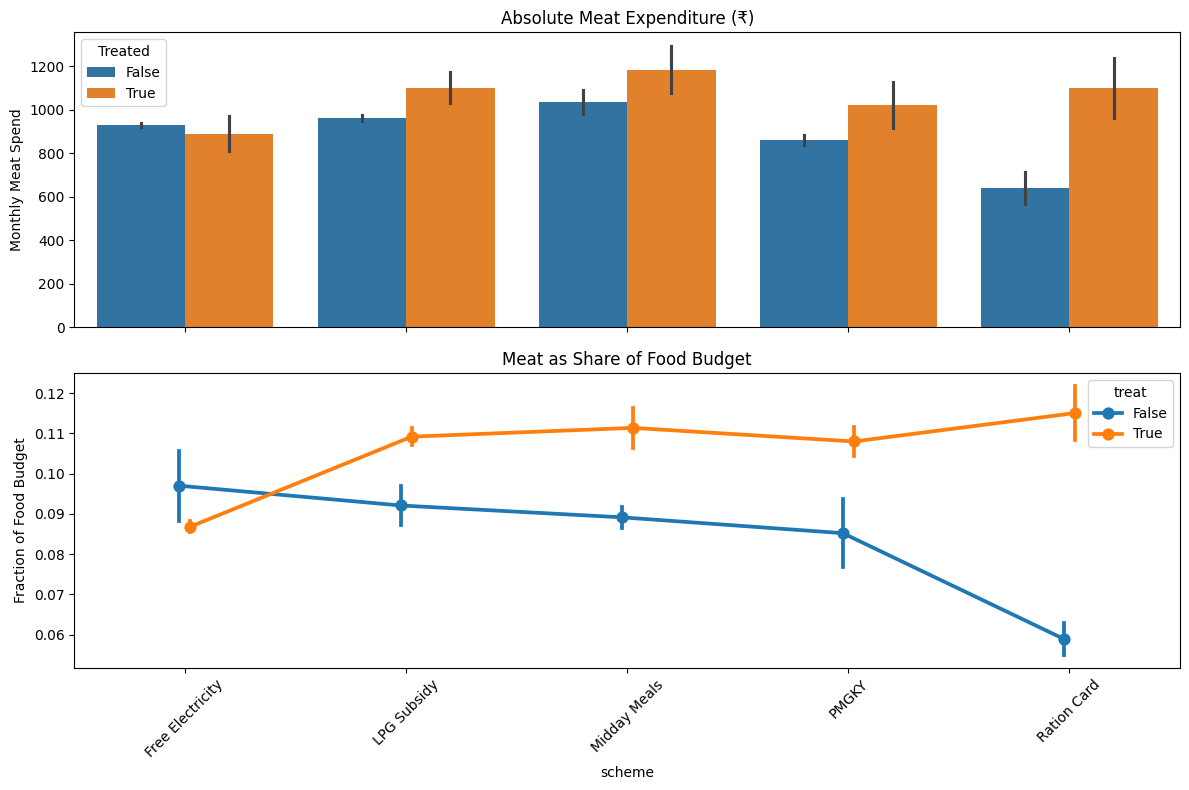

In [19]:
m = mdata.reset_index()

# Panel A — Absolute meat spend
g1 = (
    m.groupby(["scheme", "sector", "treat"])["meat"]
     .mean()
     .reset_index()
)

g2 = (
    m.groupby(["scheme", "sector", "treat"])["pc"]
     .mean()
     .reset_index()
)

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# --- Absolute meat ---
sns.barplot(
    data=g1,
    x="scheme",
    y="meat",
    hue="treat",
    ax=axes[0]
)

axes[0].set_title("Absolute Meat Expenditure (₹)")
axes[0].set_ylabel("Monthly Meat Spend")
axes[0].legend(title="Treated")

# --- Meat share ---
sns.pointplot(
    data=g2,
    x="scheme",
    y="pc",
    hue="treat",
    dodge=True,
    ax=axes[1]
)

axes[1].set_title("Meat as Share of Food Budget")
axes[1].set_ylabel("Fraction of Food Budget")

plt.xticks(rotation=45)
plt.tight_layout()

In [26]:
def meat_religion(name, treat, eligibility):
    xdf = eligibility.copy()
    xdf['treat'] = treat.loc[xdf.index]
    return xdf.groupby(['sector', 'hoh_religion', 'treat']).apply(_meat_pc)

mrdata = []
for k in INTERVENTIONS:
    mrdata.append(meat_religion(**k))
mrdata = pd.concat(mrdata, axis=0, keys=[k['name'] for k in INTERVENTIONS], verify_integrity=True)
mrdata.index.names = ['scheme' ] +  mrdata.index.names[1:]

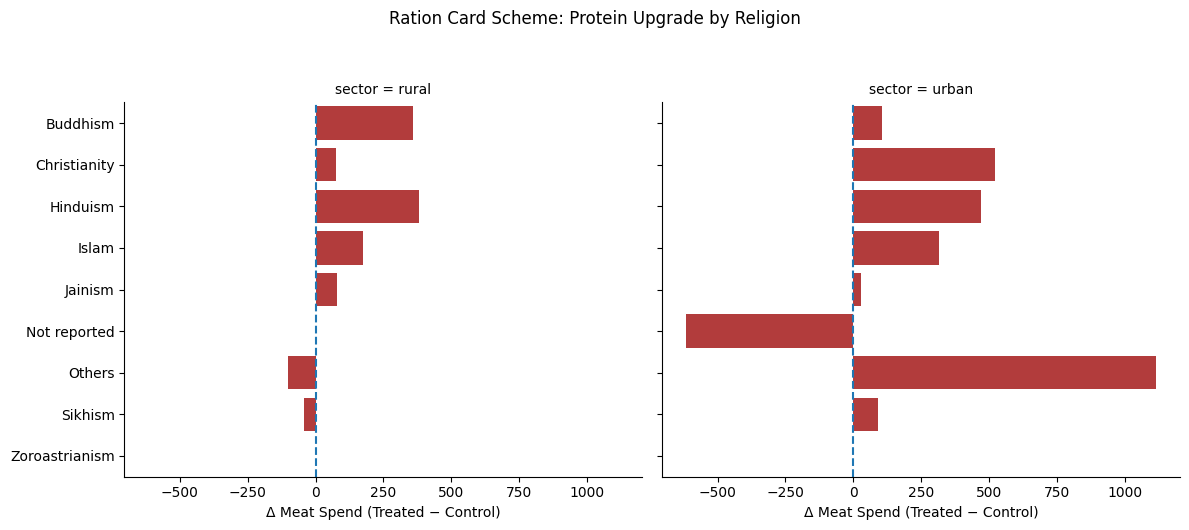

In [35]:
m = mrdata.reset_index()

# Filter
m = m[m["scheme"] == "Ration Card"]

g = (
    m.groupby(["sector", "hoh_religion", "treat"])["meat"]
     .mean()
     .reset_index()
)

pivot = g.pivot(
    index=["sector", "hoh_religion"],
    columns="treat",
    values="meat"
).reset_index()

pivot["delta_meat"] = pivot[True] - pivot[False]

g = sns.FacetGrid(
    pivot,
    col="sector",
    sharex=True,
    sharey=True,
    height=5,
    aspect=1.2
)

g.map_dataframe(
    sns.barplot,
    x="delta_meat",
    y="hoh_religion",
    color="#C62828"
)

for ax in g.axes.flat:
    ax.axvline(0, linestyle="--")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

g.set_axis_labels("Δ Meat Spend (Treated − Control)", "")
g.fig.suptitle("Ration Card Scheme: Protein Upgrade by Religion", y=1.05)

plt.tight_layout()
plt.show()

---
## Utilities

In [37]:
[i['name'] for i in INTERVENTIONS]

['PMGKY', 'Ration Card', 'Midday Meals', 'LPG Subsidy', 'Free Electricity']

In [53]:
lpg = INTERVENTIONS[-2]


def _edu_spend(x):
    y = x[edu.columns].fillna(0)
    y['books'] = y.pop('books_1st') + y.pop('books_2nd')
    return (y * x['multiplier'].values.reshape(-1, 1)).sum(axis=0) / x['multiplier'].sum()


def lpg_subsidy_edu(name, treat, eligibility):
    xdf = eligibility.copy()
    xdf['treat'] = treat.loc[xdf.index]
    
    # People who have children enrolled
    xdf = xdf[xdf['n_children'] > 0]
    xdf = xdf[xdf['is_hhmem_edu'] == 1]
    
    return xdf.groupby(['sector', 'caste', 'treat']).apply(_edu_spend).drop(['edu_other'], axis=1)

edu_lpg = lpg_subsidy_edu(**lpg)
edu_lpg

stationery        fees    coaching  \
sector caste                      treat                                       
rural  Not reported               False  114.186397  908.447873  142.152879   
                                  True    80.564126  503.600979   10.215143   
       other backward class (OBC) False  105.524912  561.331386   94.794036   
                                  True   120.055389  535.591295  163.313147   
       others                     False  112.871915  624.132833  138.663066   
                                  True   123.827058  631.511801  277.492023   
       scheduled caste (SC)       False  100.835906  441.059709  101.302013   
                                  True   123.803601  419.836476  138.031570   
       scheduled tribe (ST)       False   87.224493  359.912638   64.833508   
                                  True   104.828634  356.910220   99.927731   
urban  Not reported               False   93.254607  690.056100  282.758078   
                                  True   112.984695  406.780251  312.175498   
       other backward class (OBC) False  116.172350  680.789577  158.210998   
                                  True   131.153770  663.444543  202.484691   
       others                     False  134.139474  691.645884  260.263635   
                                  True   124.919442  634.091351  387.192130   
       scheduled caste (SC)       False  108.333886  632.905196  154.823186   
                                  True   126.780583  579.024710  244.953965   
       scheduled tribe (ST)       False  106.112267  677.663177  160.423942   
                                  True    97.902725  628.837675  146.082603   

                                              books  
sector caste                      treat              
rural  Not reported               False  193.449078  
                                  True    93.543393  
       other backward class (OBC) False  183.754029  
                                  True   196.260967  
       others                     False  200.831987  
                                  True   218.348237  
       scheduled caste (SC)       False  159.090221  
                                  True   173.349823  
       scheduled tribe (ST)       False  156.870447  
                                  True   148.441536  
urban  Not reported               False  217.433895  
                                  True   204.795898  
       other backward class (OBC) False  241.053494  
                                  True   279.938937  
       others                     False  268.381453  
                                  True   254.025859  
       scheduled caste (SC)       False  227.563409  
                                  True   218.298467  
       scheduled tribe (ST)       False  217.564080  
                                  True   192.528644

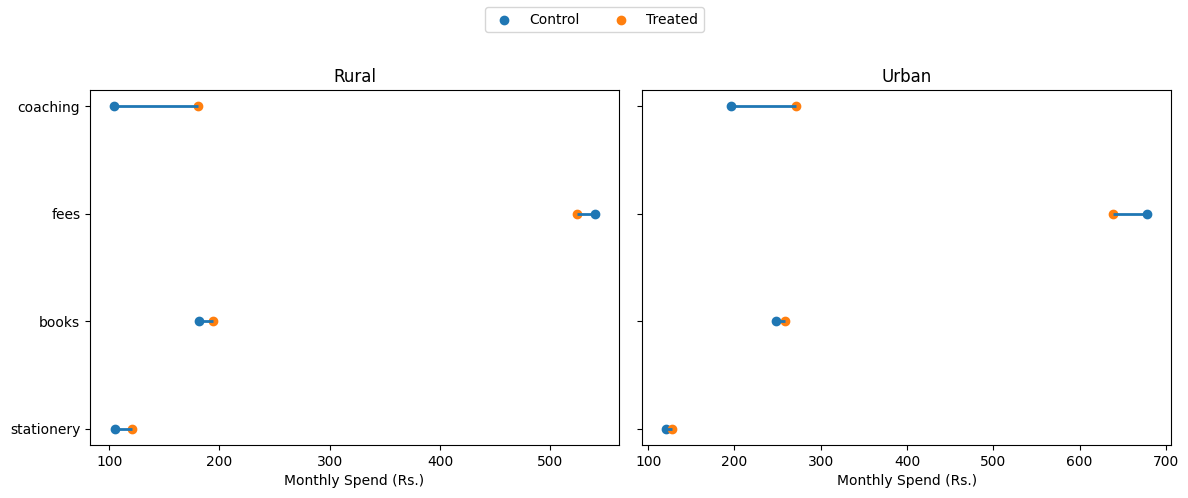

In [52]:
items = ['stationery', 'books', 'fees', 'coaching']
sectors = ['rural', 'urban']

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, sector in zip(axes, sectors):
    sub = edu_lpg.loc[sector]   # index: treat (False, True)
    
    control = sub.loc[False, items]
    treated = sub.loc[True, items]
    
    y = np.arange(len(items))
    
    ax.hlines(y, control, treated, linewidth=2)
    
    sc_control = ax.scatter(control, y, label="Control")
    sc_treated = ax.scatter(treated, y, label="Treated")
    
    ax.set_yticks(y)
    ax.set_yticklabels(items)
    ax.set_title(sector.capitalize())
    ax.set_xlabel("Monthly Spend (Rs.)")

# single shared legend
fig.legend([sc_control, sc_treated], ["Control", "Treated"],
           loc="upper center", ncol=2)

plt.tight_layout(rect=[0, 0, 1, 0.9])

In [60]:
elec = INTERVENTIONS[-1]


def _fees(x):
    x = x[x['n_children'] > 0]
    x = x[x['is_hhmem_edu'] == 1]
    return (x['fees'] / x['n_children'] * x['multiplier']).sum() / x['multiplier'].sum()

def _dairy_pc(x):
    return (x['dairy'] / x['family_size'] * x['multiplier']).sum() / x['multiplier'].sum()


def _cooked_food(x):
    return (x['cooked'] / x['family_size'] * x['multiplier']).sum() / x['multiplier'].sum()


def free_elec(name, treat, eligibility):
    xdf = eligibility.copy()
    xdf['treat'] = treat.loc[xdf.index]
    
    gb = xdf.groupby(['sector', 'treat'])
    fees = gb.apply(_fees)
    dairy = gb.apply(_dairy_pc)
    cooked = gb.apply(_cooked_food)
    y = pd.concat([fees, dairy, cooked], axis=1)
    y.columns = ['Fees', 'Dairy', 'Cooked Food']
    return y

elec_stuff = free_elec(**elec)

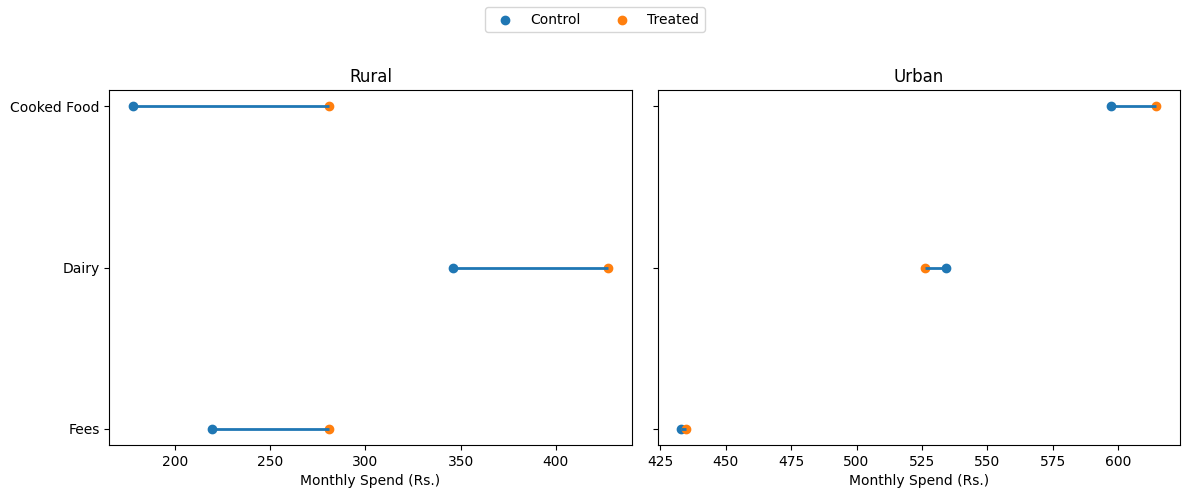

In [61]:
items = ['Fees', 'Dairy', 'Cooked Food']
sectors = ['rural', 'urban']

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, sector in zip(axes, sectors):
    sub = elec_stuff.loc[sector]   # index: treat (False, True)
    
    control = sub.loc[False, items]
    treated = sub.loc[True, items]
    
    y = np.arange(len(items))
    
    ax.hlines(y, control, treated, linewidth=2)
    
    sc_control = ax.scatter(control, y, label="Control")
    sc_treated = ax.scatter(treated, y, label="Treated")
    
    ax.set_yticks(y)
    ax.set_yticklabels(items)
    ax.set_title(sector.capitalize())
    ax.set_xlabel("Monthly Spend (Rs.)")

# single shared legend
fig.legend([sc_control, sc_treated], ["Control", "Treated"],
           loc="upper center", ncol=2)

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()